In [28]:
# TMP: print all labels
import os

# Path to your dataset directory
dataset_directory = "E:/MyDatasets/hagrid_dataset_512"

# List to hold folder names
folder_names = []

# Check if the directory exists
if os.path.exists(dataset_directory):
    # Iterate over all items in the directory
    for item in os.listdir(dataset_directory):
        # Construct full path
        item_path = os.path.join(dataset_directory, item)
        # Check if it's a directory and not a file
        if os.path.isdir(item_path):
            folder_names.append(item)  # Add the folder name to the list
else:
    print(f"Directory does not exist: {dataset_directory}")

# Now, folder_names list contains all the folder names in the specified directory
print(folder_names)


['call', 'dislike', 'fist', 'four', 'like', 'mute', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted']


# Gesture Classification

This notebook is used to train classification models from csv dataset. 

> shift and rotation 

<a href="#evaluation">Go to Evaluation Cell</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
# set up
from DataPrepare import HandDataPrepare
HandLandmarkPrepare = HandDataPrepare()

dataset = 'datasets/HandLandmarks.csv'
model_save_path = 'models/gesture_classifier.hdf5'
tflite_save_path = 'models/gesture_classifier.tflite'

LABELS = HandLandmarkPrepare.LABELS
NUM_CLASSES = HandLandmarkPrepare.NUM_CLASSES

## Dataset Preparation

In [3]:
# Load the datasets and apply train_test_split
df = pd.read_csv(dataset, header=None, dtype='float32')

y_dataset = df.iloc[:, 0].values.astype('int32')
X_dataset = df.iloc[:, 1:].values

In [4]:
X_dataset

array([[ 1.        ,  0.        ,  0.        , ..., -0.10216434,
        -0.13508339, -0.03064877],
       [ 0.        ,  0.        ,  0.        , ...,  0.14574052,
        -0.14397112, -0.05501493],
       [ 0.        ,  0.        ,  0.        , ...,  0.11213671,
        -0.14468998, -0.03186031],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.03444985,
        -0.13605247, -0.00870891],
       [ 1.        ,  0.        ,  0.        , ..., -0.08305884,
        -0.10387042, -0.01509997],
       [ 1.        ,  0.        ,  0.        , ..., -0.07646123,
        -0.09891637, -0.00968494]], dtype=float32)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [6]:
y_train

array([11, 10,  4, ...,  5,  0,  7])

In [7]:
X_train[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -3.84705365e-02, -4.04734761e-02, -5.18343132e-03, -5.13279475e-02,
       -7.90716410e-02, -8.85298010e-03, -4.31692600e-02, -1.11090571e-01,
       -1.25077050e-02, -2.77799889e-02, -1.24602810e-01, -1.57617237e-02,
        7.92261845e-18, -1.02456622e-01, -4.73904982e-03,  2.17009895e-02,
       -1.41244307e-01, -1.19626960e-02,  3.50580178e-02, -1.62744284e-01,
       -1.69818103e-02,  4.68660519e-02, -1.79199353e-01, -2.05787234e-02,
        3.27351689e-02, -9.29414183e-02, -6.57391502e-03,  5.62498607e-02,
       -1.37038067e-01, -1.24754729e-02,  6.82639554e-02, -1.62858278e-01,
       -1.60586387e-02,  7.92608112e-02, -1.82582468e-01, -1.89216938e-02,
        5.86342514e-02, -7.90141895e-02, -9.51563288e-03,  8.14785138e-02,
       -1.20038964e-01, -1.52714122e-02,  9.30225775e-02, -1.44597679e-01,
       -1.92355644e-02,  1.01017691e-01, -1.64029121e-01, -2.17267089e-02,
        7.89035335e-02, -

In [8]:
print(y_train.shape, X_train.shape, y_test.shape, X_test.shape)

(9000,) (9000, 64) (3000,) (3000, 64)


## Model Building

In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((NUM_CLASSES * 3 + 1, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dropout(0.1),  # Adjusted dropout rate
    tf.keras.layers.Dense(128, activation='relu'),  # Increased units
    tf.keras.layers.BatchNormalization(),  # Added Batch Normalization
    tf.keras.layers.Dense(64, activation='relu'),  # Increased units
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 batch_normalization_1 (Bat  (None, 128)               512       
 chNormalization)                                       

In [11]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=30, verbose=1)

In [12]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

## Model Training

In [13]:
es_callback

In [14]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000




54/71 [=====================>........] - ETA: 0s - loss: 1.8273 - accuracy: 0.4236
Epoch 1: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 3s 8ms/step - loss: 1.6538 - accuracy: 0.4859 - val_loss: 2.4020 - val_accuracy: 0.0850
Epoch 2/1000
37/71 [==============>...............] - ETA: 0s - loss: 0.8496 - accuracy: 0.7508

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/71 [======================>.......] - ETA: 0s - loss: 0.7977 - accuracy: 0.7617
Epoch 2: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 0.7702 - accuracy: 0.7691 - val_loss: 2.3220 - val_accuracy: 0.0853
Epoch 3/1000
56/71 [======================>.......] - ETA: 0s - loss: 0.5405 - accuracy: 0.8283
Epoch 3: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 0.5228 - accuracy: 0.8342 - val_loss: 2.1511 - val_accuracy: 0.0910
Epoch 4/1000
71/71 [==============================] - ETA: 0s - loss: 0.4152 - accuracy: 0.8677
Epoch 4: saving model to models\gesture_classifier.hdf5
71/71 [==============================] - 0s 4ms/step - loss: 0.4152 - accuracy: 0.8677 - val_loss: 1.7384 - val_accuracy: 0.2440
Epoch 5/1000
57/71 [=======================>......] - ETA: 0s - loss: 0.3662 - accuracy: 0.8829
Epoch 5: saving model to models\gesture_classifier.hdf5
71/71 [===========

In [15]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

24/24 [==============================] - 0s 2ms/step - loss: 0.0938 - accuracy: 0.9773


In [16]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [17]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 186ms/step
[5.34415130e-06 8.98806810e-01 1.00351743e-01 4.32010012e-04
 1.33324975e-05 1.70505391e-05 3.58284306e-04 3.59955970e-06
 1.86644763e-06 9.23605876e-06 7.40073176e-07 5.34275202e-09]
1


# Confusion matrix

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

<a id="evaluation"></a>

### Evaluation 

42/94 [============>.................] - ETA: 0s

94/94 [==============================] - 0s 1ms/step


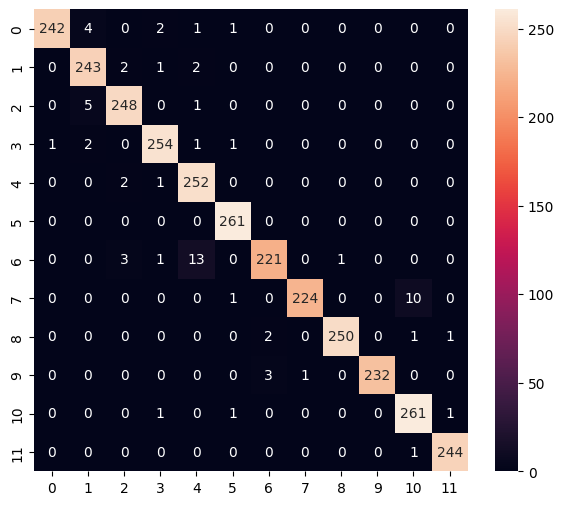

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       250
           1       0.96      0.98      0.97       248
           2       0.97      0.98      0.97       254
           3       0.98      0.98      0.98       259
           4       0.93      0.99      0.96       255
           5       0.98      1.00      0.99       261
           6       0.98      0.92      0.95       239
           7       1.00      0.95      0.97       235
           8       1.00      0.98      0.99       254
           9       1.00      0.98      0.99       236
          10       0.96      0.99      0.97       264
          11       0.99      1.00      0.99       245

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



In [19]:
Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

## Convert to model for Tensorflow-Lite

In [20]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Users\Ian\git\553.806_Capstone_HandGesture\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
# Transform model (quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmpglgp2i2r\assets


INFO:tensorflow:Assets written to: C:\Users\Ian\AppData\Local\Temp\tmpglgp2i2r\assets


40376

### Inference test

In [22]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [23]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [24]:
np.array([X_test[0]])

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -9.98144783e-03, -2.23025344e-02,
        -6.88415999e-03, -1.77429337e-02, -4.67161685e-02,
        -1.12438109e-02, -2.39255875e-02, -6.48192242e-02,
        -1.62647236e-02, -3.07960026e-02, -7.62352794e-02,
        -1.95785016e-02,  3.75132959e-17, -6.53303191e-02,
        -4.71468054e-04,  2.75991624e-04, -7.58573189e-02,
        -9.61074326e-03, -3.19577032e-03, -5.69726638e-02,
        -1.42947678e-02, -2.59770849e-03, -5.04614040e-02,
        -1.66317876e-02,  1.11168632e-02, -6.28402531e-02,
        -1.64122332e-03,  1.04519129e-02, -6.97992146e-02,
        -1.06204376e-02,  4.95113898e-03, -4.94120605e-02,
        -1.10188648e-02,  4.78710653e-03, -4.57057171e-02,
        -9.86819528e-03,  2.06429958e-02, -5.75499795e-02,
        -4.91535058e-03,  2.00364944e-02, -6.24663867e-02,
        -1.36479540e-02,  1.37048271e-02, -4.45249192e-02,
        -9.57841892e-03,  1.24939857e-02, -4.03831378e-0

In [25]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[3.7963555e-06 8.0753505e-01 1.9163644e-01 2.4791746e-04 1.1826835e-05
 1.6896969e-05 5.2427425e-04 2.7658637e-06 1.8526412e-06 1.8325853e-05
 8.3531842e-07 5.9611156e-09]
1
CPU times: total: 0 ns
Wall time: 0 ns
